In [2]:
# This section installs packages needed to run the script. 

import folium
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import openeo
from shapely.geometry import shape, Point
from rasterio import warp
from matplotlib import cm
from matplotlib.colors import Normalize
import folium.raster_layers
import rasterio
from rasterio import warp
import numpy as np
import requests

# WARNING - If you wish to run this tool twice (for different dates) then the kernel will need to be reset each time. 

In [3]:
#This establishes a connection with the Sentenel satelite data. 

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

#if this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 
#if you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 
#if there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
landfill_csv = pd.read_csv(r'C:\GIS_Course\EGM722\Project\Data\PreZero_Landfill_Bounding.csv')

landfill_csv

,id,Landfill,west,south,east,north
0,0,ALBACETE,-1.821766,38.959673,-1.731934,39.029490
1,1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,-2.218884,37.354949,-2.129053,37.426322
2,2,ALCALA DEL RIO (LA VEGA-SEVILLA),-6.044366,37.563595,-5.954534,37.634768
3,3,ALCAZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,-3.270015,39.398232,-3.180184,39.467615
4,4,ALMERIA: CMA,-2.331662,36.842943,-2.241830,36.914799
5,5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,1.761472,41.497221,1.851303,41.564469
6,6,CANADA HERMOSA: MURCIA,-1.332995,37.945271,-1.243163,38.016078
7,7,DAIMIEL,-3.629513,39.029644,-3.539682,39.099392
8,8,ECOPARQUE DE TOLEDO: GESMAT,-4.208720,39.826702,-4.118888,39.895657
9,9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),-15.468487,28.019118,15.378655,28.098392


In [6]:
# Read the CSV file containing landfill data
landfills_df = pd.read_csv(r'C:\GIS_Course\EGM722\Project\Data\PreZero_Landfill_Bounding.csv')

def get_spatial_extent(landfill_id):
    landfill = landfills_df[landfills_df['id'] == landfill_id].iloc[0]
    return {
        "west": landfill['west'],
        "south": landfill['south'],
        "east": landfill['east'],
        "north": landfill['north']
    }

def fetch_available_dates(landfill_id, temporal_extent):
    spatial_extent = get_spatial_extent(landfill_id)
    catalog_url = f"https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json?box={spatial_extent['west']}%2C{spatial_extent['south']}%2C{spatial_extent['east']}%2C{spatial_extent['north']}&sortParam=startDate&sortOrder=ascending&page=1&maxRecords=1000&status=ONLINE&dataset=ESA-DATASET&productType=L2A&startDate={temporal_extent[0]}T00%3A00%3A00Z&completionDate={temporal_extent[1]}T00%3A00%3A00Z"
    response = requests.get(catalog_url)
    response.raise_for_status()
    catalog = response.json()
    dates = [date.split('T')[0] for date in map(lambda x: x['properties']['startDate'], catalog['features'])]
    return dates

# Please enter your perameters here.
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2021-08-01", "2021-10-31"]
available_dates = fetch_available_dates(landfill_id, temporal_extent)
max_cloud_cover=5, #max tolerated cloud cover in %
print("Available dates:", available_dates)


Available dates: ['2021-08-01', '2021-08-01', '2021-08-04', '2021-08-04', '2021-08-06', '2021-08-06', '2021-08-09', '2021-08-09', '2021-08-11', '2021-08-11', '2021-08-14', '2021-08-14', '2021-08-16', '2021-08-16', '2021-08-19', '2021-08-19', '2021-08-21', '2021-08-21', '2021-08-24', '2021-08-24', '2021-08-26', '2021-08-26', '2021-08-29', '2021-08-29', '2021-08-31', '2021-08-31', '2021-09-03', '2021-09-03', '2021-09-05', '2021-09-05', '2021-09-08', '2021-09-08', '2021-09-10', '2021-09-10', '2021-09-13', '2021-09-13', '2021-09-15', '2021-09-15', '2021-09-18', '2021-09-18', '2021-09-20', '2021-09-20', '2021-09-23', '2021-09-23', '2021-09-25', '2021-09-25', '2021-09-28', '2021-09-28', '2021-09-30', '2021-09-30', '2021-10-03', '2021-10-03', '2021-10-05', '2021-10-05', '2021-10-08', '2021-10-08', '2021-10-10', '2021-10-10', '2021-10-13', '2021-10-13', '2021-10-15', '2021-10-15', '2021-10-18', '2021-10-18', '2021-10-20', '2021-10-20', '2021-10-23', '2021-10-23', '2021-10-25', '2021-10-25', '2

In [54]:
def active_emission(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    active_emission = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B12"],
        max_cloud_cover=95,
    )
    active_emission.download("Sentinel-2_active_emission.GTiff")

# Enter perameters for the active emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2021-10-15", "2021-10-15"]
active_emission(landfill_id, temporal_extent)

# If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.


In [55]:
def no_emission(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    no_emission_collection = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B12"],
    )
    no_emission_collection.download("Sentinel-2_no_emission.GTiff")

# Enter parameters for the no emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2021-09-05", "2021-09-05"]
no_emission(landfill_id, temporal_extent)

# If you receive an error message of 'NoDataAvailable' then please check the list of available data above and try again.



In [63]:
# this section does the band maths on the two downloaded images. 

# Load the GeoTIFF files
with rasterio.open(r"C:\GIS_Course\EGM722\Project\Sentinel-2_active_emission.GTiff") as active_emission_file:
    active_emission_data = active_emission_file.read(1)  # the only band (band 1) is B12 from the data

with rasterio.open(r"C:\GIS_Course\EGM722\Project\Sentinel-2_no_emission.GTiff") as no_emission_file:
    no_emission_data = no_emission_file.read(1)   # the only band (band 1) is B12 from the data

# Calculate methane column
methane_column = (active_emission_data - no_emission_data) / no_emission_data



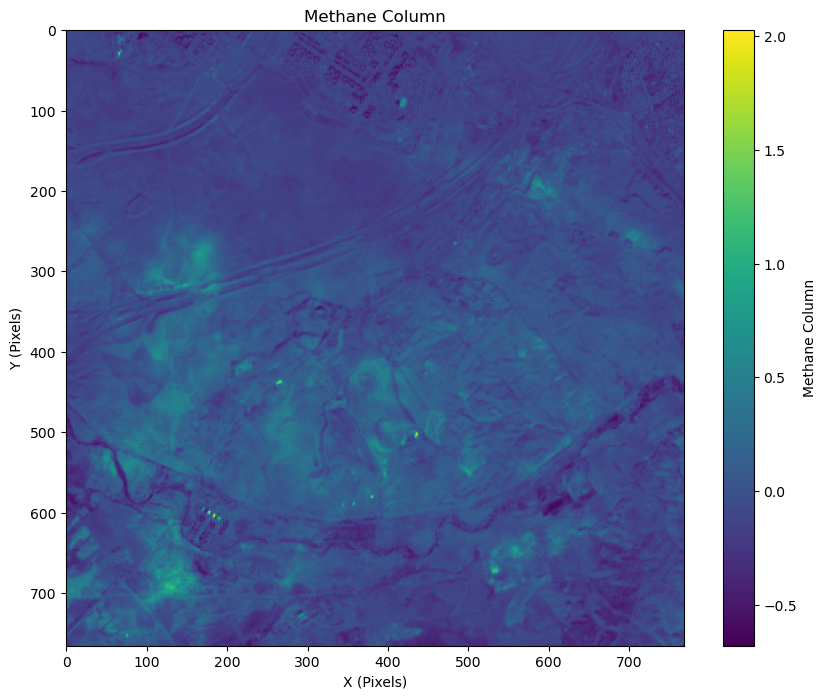

In [65]:
plt.figure(figsize=(10, 8))
plt.imshow(methane_column, cmap='viridis')
plt.colorbar(label='Methane Column')
plt.title('Methane Column')
plt.xlabel('X (Pixels)')
plt.ylabel('Y (Pixels)')
plt.show()